<a href="https://colab.research.google.com/github/Navaneeth984/A_N_D_Major_project_Credit_Card_fraud_Detection/blob/main/A_N_D_Major_project_Credit_Card_fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [ ]:
df = pd.read_csv("card_transdata.csv")

In [ ]:
df.shape

(13747, 8)

In [ ]:
df.isnull().values.any()

True

In [ ]:
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


Text(0, 0.5, 'Frequency')

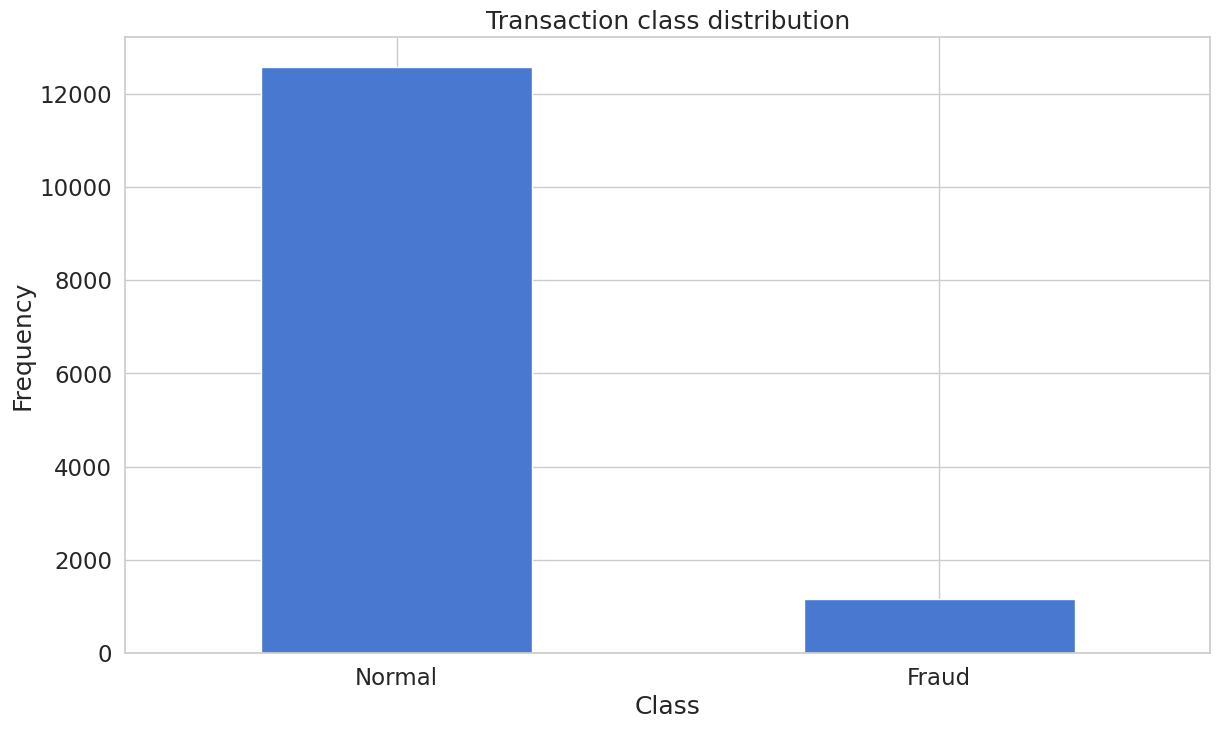

In [ ]:
count_classes = pd.value_counts(df['fraud'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

In [ ]:
frauds = df[df.fraud == 1]
normal = df[df.fraud == 0]

In [ ]:
frauds.shape

(1166, 8)

In [ ]:
normal.shape

(12580, 8)

In [ ]:
frauds.distance_from_home.describe()

count    1166.000000
mean       65.267406
std       142.836267
min         0.122193
25%         4.597739
50%        13.620964
75%        78.231527
max      2353.226927
Name: distance_from_home, dtype: float64

In [ ]:
normal.distance_from_home.describe()

count    12580.000000
mean        23.438876
std         50.666492
min          0.049270
25%          3.779250
50%          9.801033
75%         24.754565
max       2146.055760
Name: distance_from_home, dtype: float64

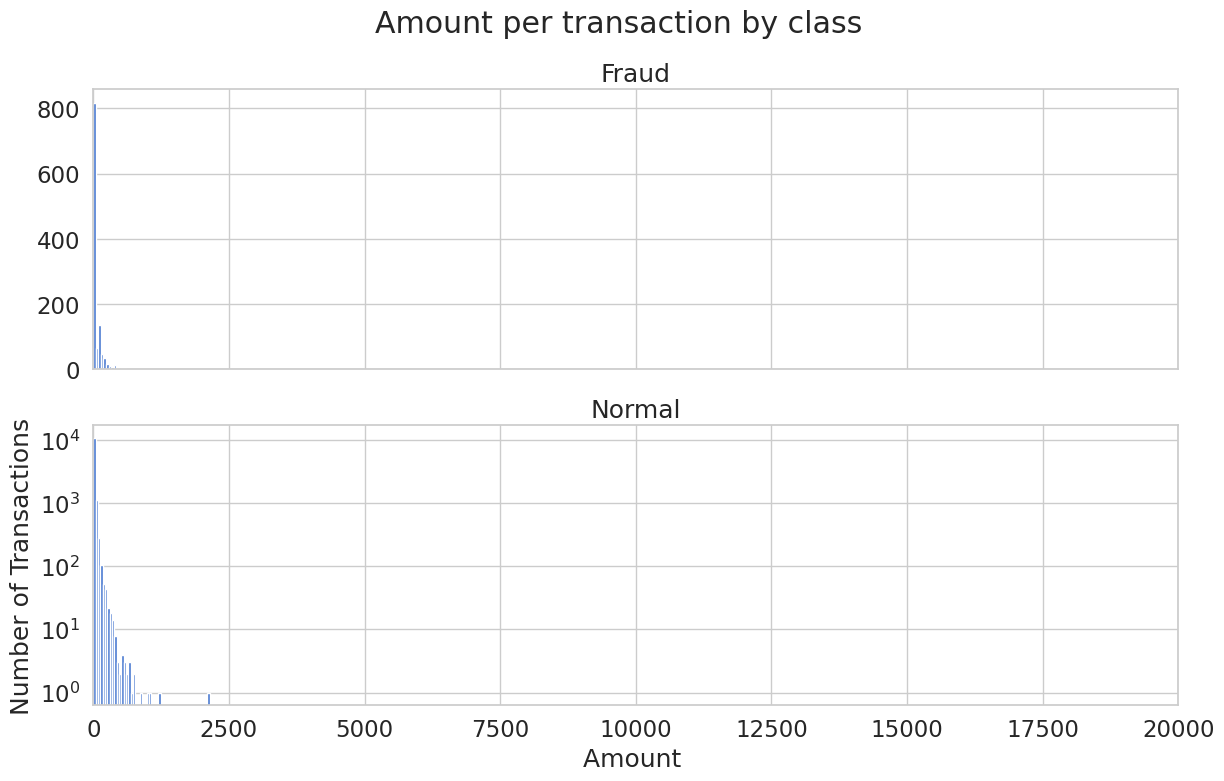

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.distance_from_home, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.distance_from_home, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

Autoencoders are fascinating neural network models that might initially baffle newcomers. Essentially, their task revolves around predicting an output identical to their input. Sounds counterintuitive, right? Imagine feeding an image into a model and expecting the same image back out. But there's a twist.

In the realm of Autoencoder Neural Networks, the goal isn't just replication; it's about learning a condensed representation of the input data, thus uncovering its underlying structure. To achieve this, autoencoders typically operate with fewer hidden units than input units, resulting in what's termed an "undercomplete" autoencoder.

Visualizing an autoencoder's learning process sheds light on its purpose: it attempts to reconstruct its input data as accurately as possible while distilling its essence into a compact form.

Central to training an autoencoder is minimizing a specific type of error known as the reconstruction error. This error measures the disparity between the original input and its reconstruction by the autoencoder. Conventionally, the squared error metric is employed for this purpose.

To delve deeper into the concept of autoencoders, I recommend exploring educational resources like Hugo Larochelle's insightful videos.

Before diving into the intricacies of training an autoencoder, it's crucial to prepare the data appropriately. For instance, in a scenario involving transactional data, such as credit card transactions, one might preprocess the dataset by removing irrelevant features (e.g., timestamps) and standardizing numerical attributes like transaction amounts using tools like scikit-learn's StandardScaler. This preprocessing step ensures that the data is conducive to effective training and yields meaningful insights from the autoencoder model.

In [ ]:
from sklearn.preprocessing import StandardScaler

data = df

data['distance_from_home'] = StandardScaler().fit_transform(data['distance_from_home'].values.reshape(-1, 1))

In [ ]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.fraud == 0]
X_train = X_train.drop(['fraud'], axis=1)

y_test = X_test['fraud']
X_test = X_test.drop(['fraud'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [ ]:
X_train.shape

(10075, 7)

In [ ]:
input_dim = X_train.shape[1]
encoding_dim = 14

In [ ]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh",
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

We'll train our autoencoder for 100 epochs with a batch size of 32, saving the best model using Keras' ModelCheckpoint. Additionally, we'll export the training progress in a TensorBoard-compatible format for insightful analysis.

In [ ]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/100
315/315 [==============================] - 2s 4ms/step - loss: 37.8780 - accuracy: 0.4476 - val_loss: 53.5097 - val_accuracy: 0.6436
Epoch 2/100
 69/315 [=====>........................] - ETA: 0s - loss: 102.7955 - accuracy: 0.6490

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


315/315 [==============================] - 1s 3ms/step - loss: 35.9647 - accuracy: 0.7087 - val_loss: 51.9685 - val_accuracy: 0.7651
Epoch 3/100
315/315 [==============================] - 1s 3ms/step - loss: 34.8139 - accuracy: 0.7873 - val_loss: 50.6954 - val_accuracy: 0.8276
Epoch 4/100
315/315 [==============================] - 1s 4ms/step - loss: 33.8640 - accuracy: 0.8222 - val_loss: 49.6141 - val_accuracy: 0.8356
Epoch 5/100
315/315 [==============================] - 2s 5ms/step - loss: 33.0551 - accuracy: 0.8279 - val_loss: 48.6719 - val_accuracy: 0.8476
Epoch 6/100
315/315 [==============================] - 2s 7ms/step - loss: 32.3420 - accuracy: 0.7962 - val_loss: 47.8165 - val_accuracy: 0.8135
Epoch 7/100
315/315 [==============================] - 1s 3ms/step - loss: 31.7132 - accuracy: 0.7828 - val_loss: 47.0631 - val_accuracy: 0.7971
Epoch 8/100
315/315 [==============================] - 1s 2ms/step - loss: 31.1408 - accuracy: 0.7781 - val_loss: 46.3575 - val_accuracy: 0.79

In [ ]:
autoencoder = load_model('model.h5')

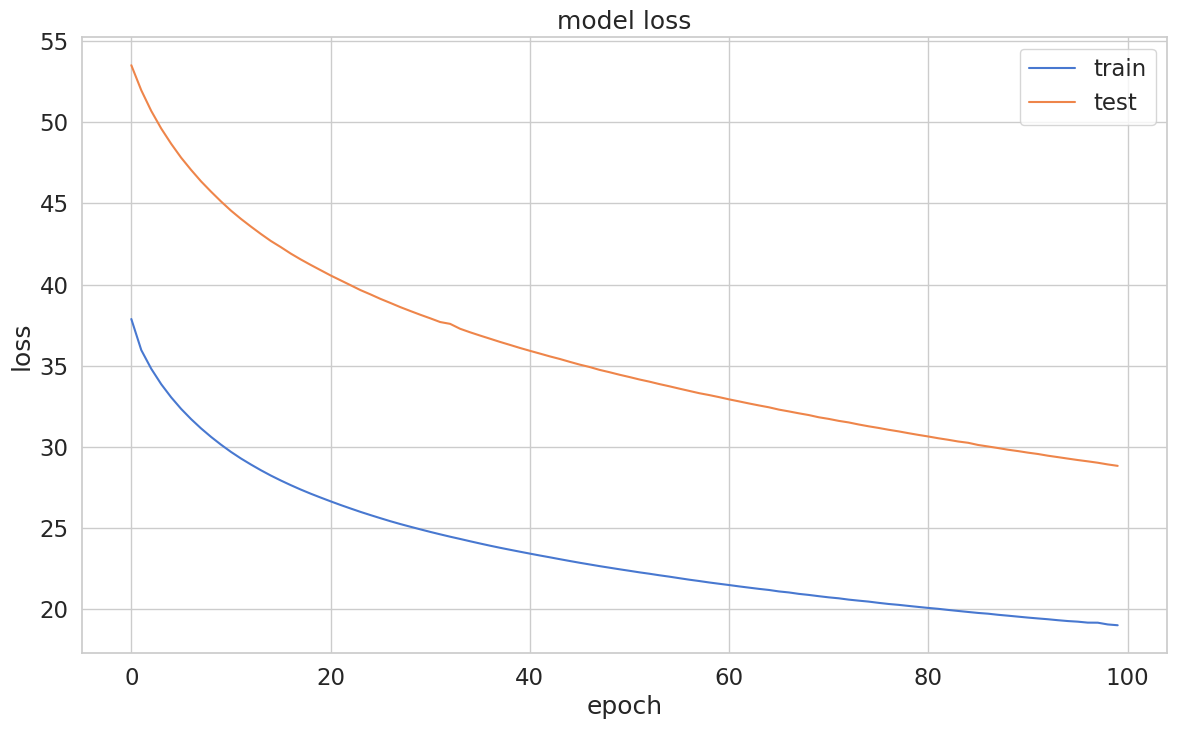

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [ ]:
predictions = autoencoder.predict(X_test)

86/86 [==============================] - 0s 3ms/step


In [ ]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [ ]:

error_df.describe()

,reconstruction_error,true_class
count,2750.000000,2750.000000
mean,28.832773,0.089091
std,865.513431,0.284927
min,0.002167,0.000000
25%,0.013375,0.000000
50%,0.024373,0.000000
75%,0.062236,0.000000
max,41145.870663,1.000000


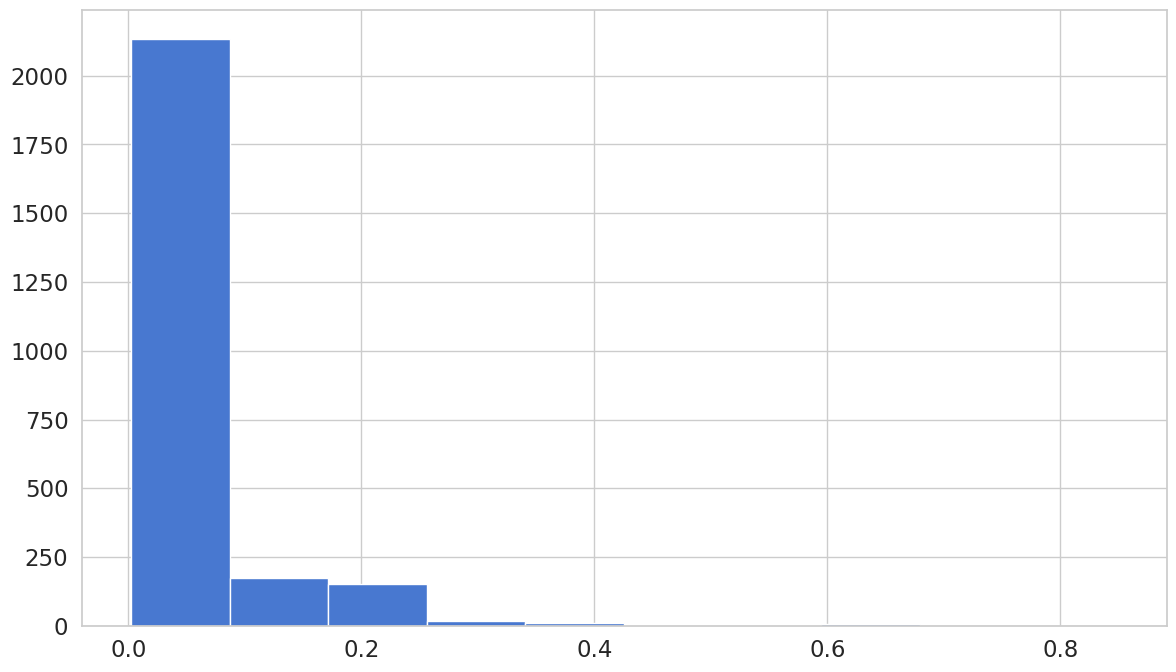

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

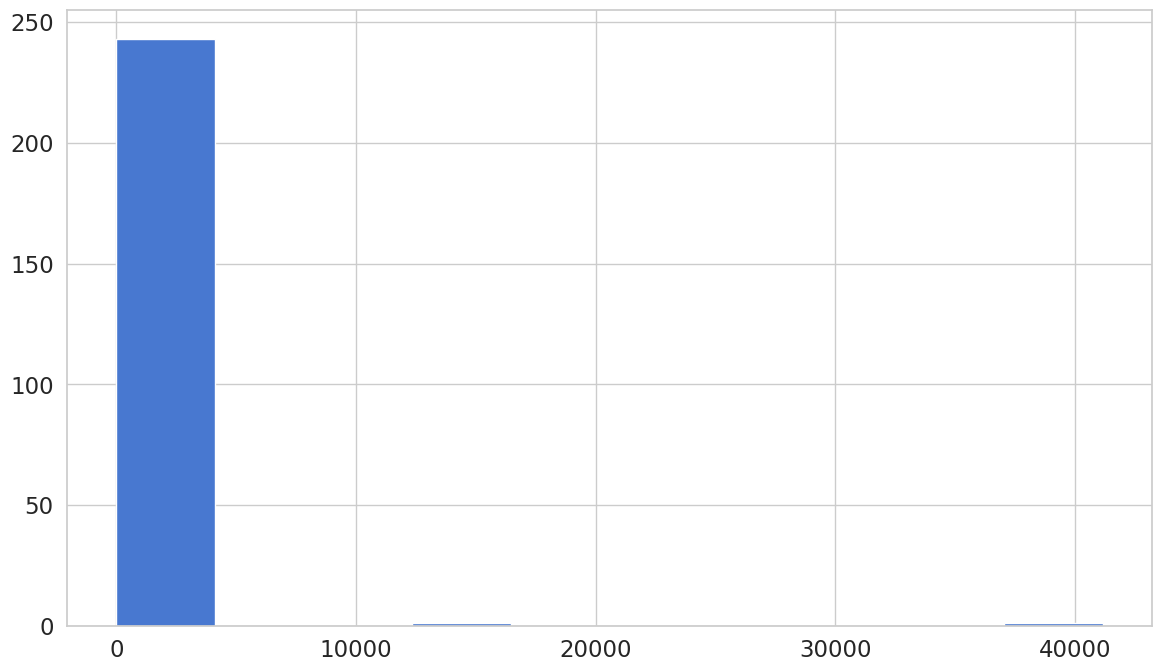

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [ ]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

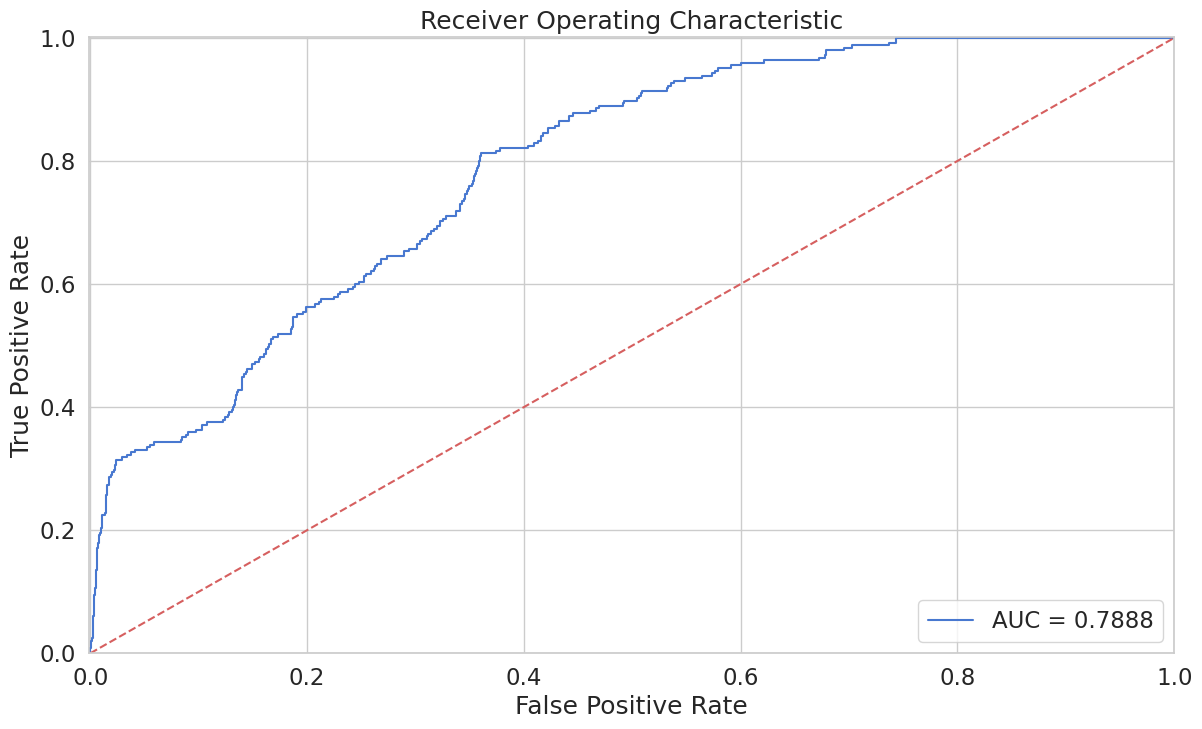

In [ ]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

The ROC curve plots the true positive rate versus the false positive rate, over different threshold values. Basically, we want the blue line to be as close as possible to the upper left corner. While our results look pretty good, we have to keep in mind of the nature of our dataset. ROC doesn't look very useful for us. Onward...

Precision and recall are defined as follows:

Let's take an example from Information Retrieval in order to better understand what precision and recall are. Precision measures the relevancy of obtained results. Recall, on the other hand, measures how many relevant results are returned. Both values can take values between 0 and 1. You would love to have a system with both values being equal to 1.

Let's return to our example from Information Retrieval. High recall but low precision means many results, most of which has low or no relevancy. When precision is high but recall is low we have the opposite - few returned results with very high relevancy. Ideally, you would want high precision and high recall - many results with that are highly relevant.

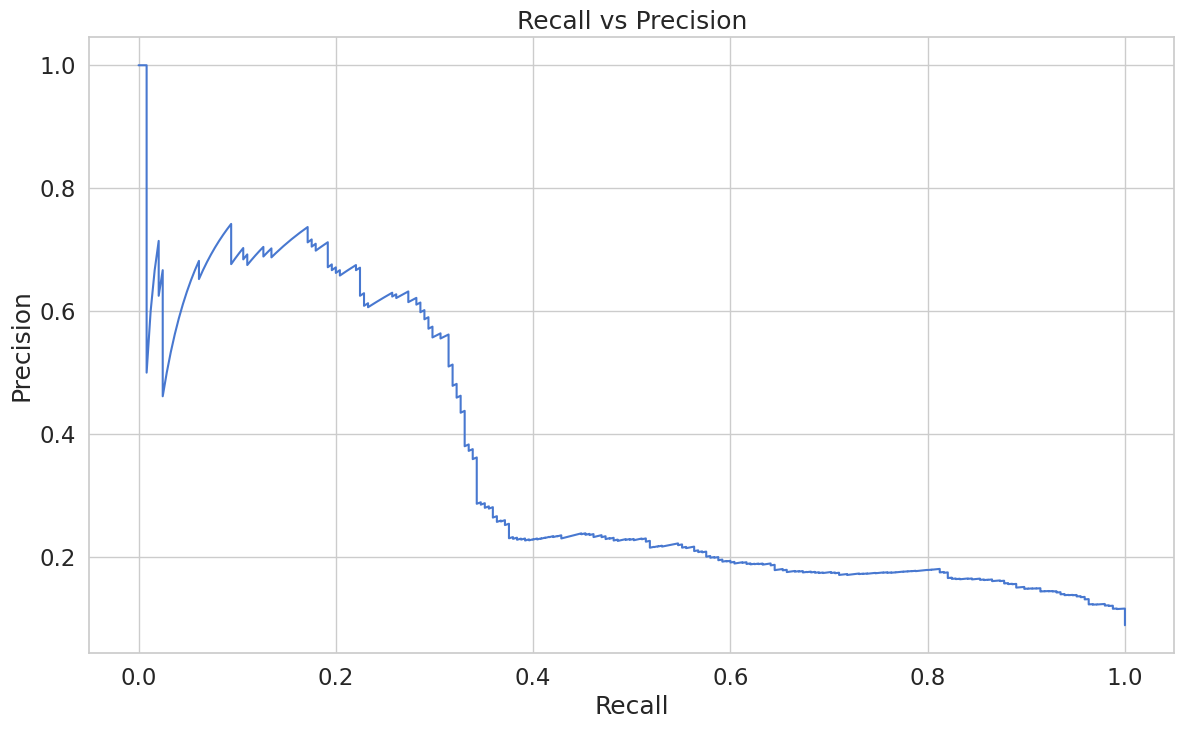

In [ ]:

precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

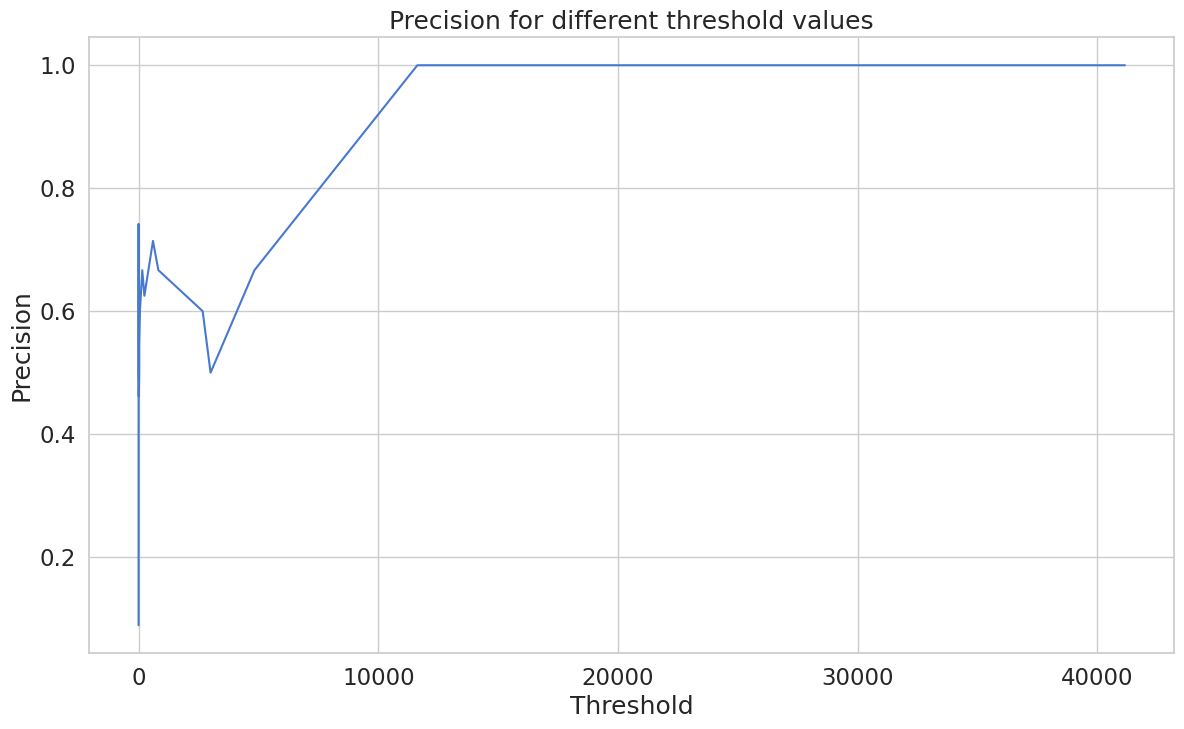

In [ ]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

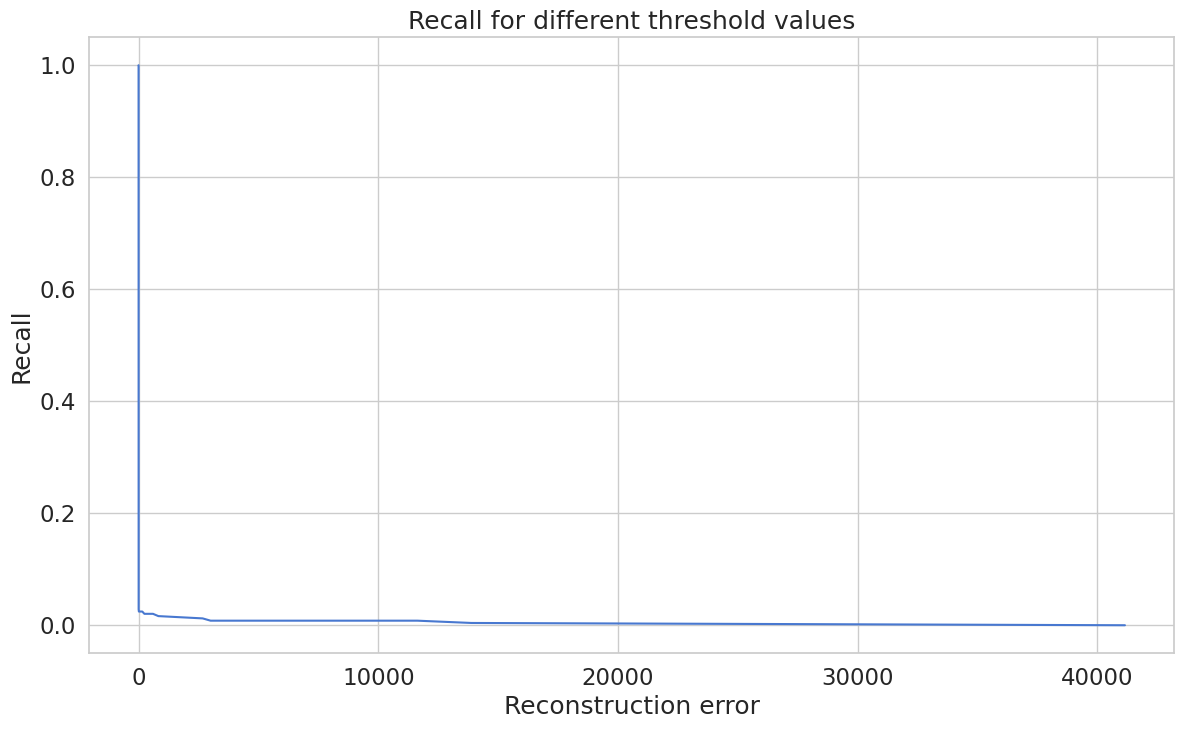

In [ ]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

In [ ]:
threshold = 2.9

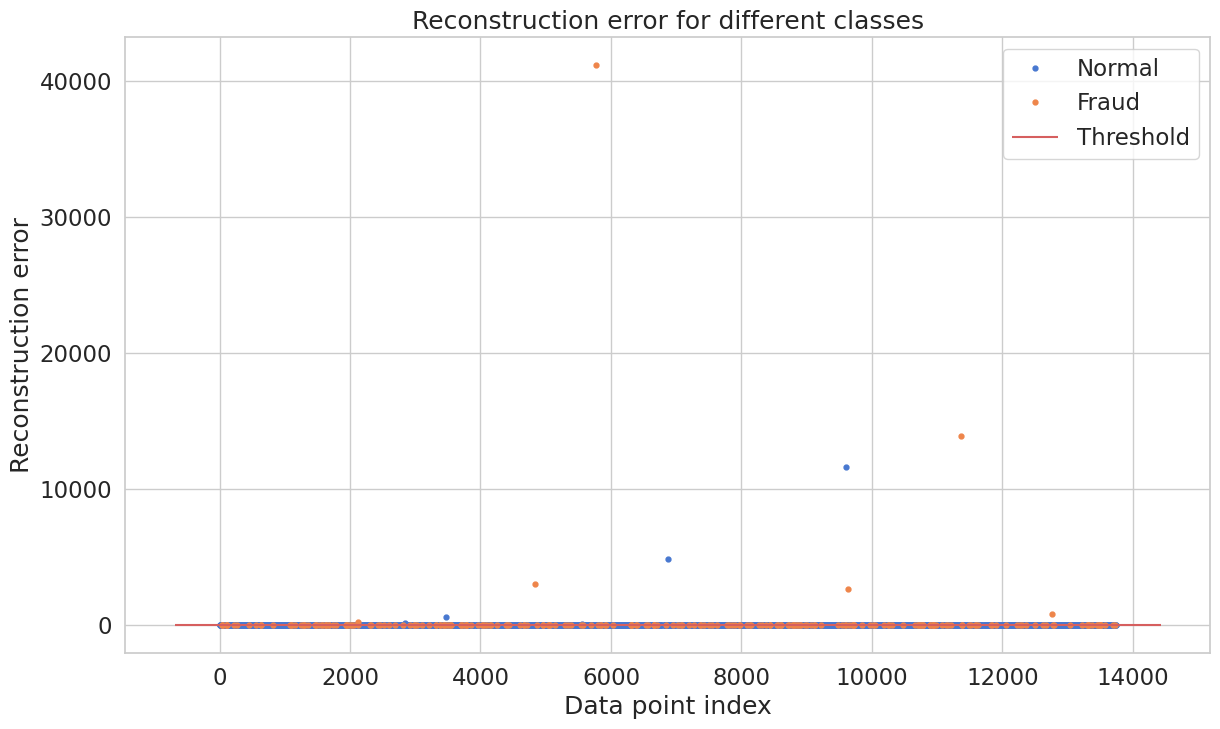

In [ ]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();


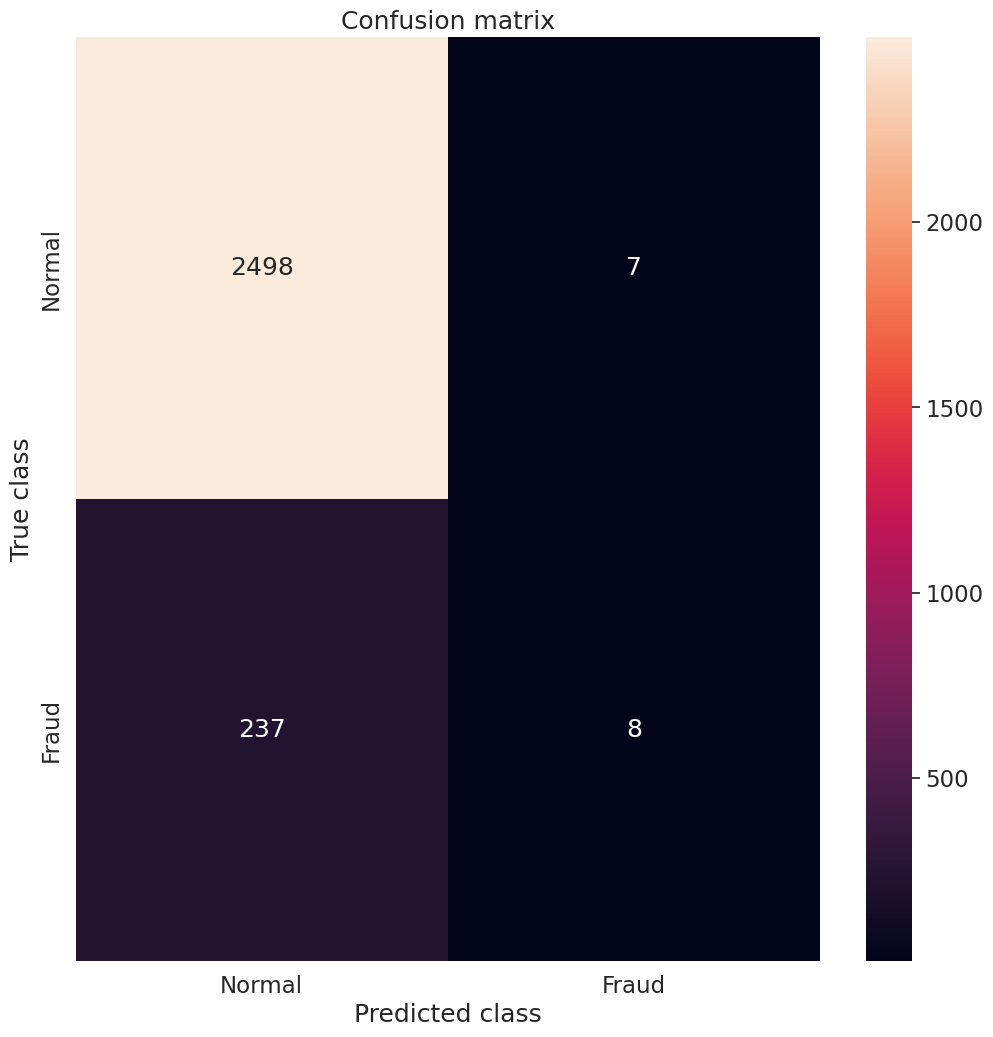

In [ ]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()